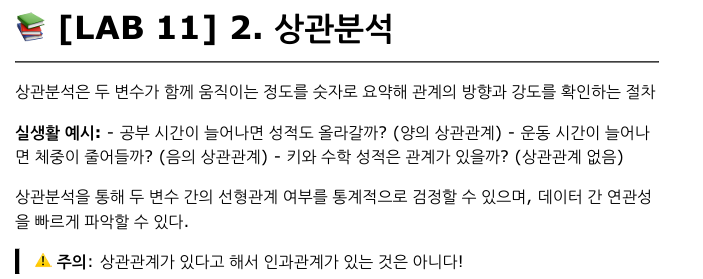

- 핵심은 인과관계를 보는 것이 아니라는 것

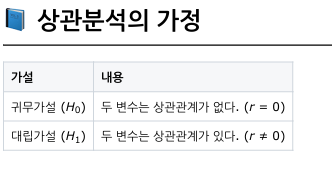

In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [2]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [53]:
origin = load_data('language_math_scores')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/language_math_scores.xlsx
[desc] 어느 학급의 언어영역과 수리영역 점수를 기록한 가상의 데이터 셋

field     type    description
--------  ------  -------------
언어영역  INT     언어영역 점수
수리영역  INT     수리영역 점수


===== 데이터 크기 확인 =====
데이터셋 크기 : (50, 2)
열 개수: 2
행 개수: 50

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   언어영역    50 non-null     int64
 1   수리영역    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,언어영역,수리영역
0,66,66
1,58,70
2,73,74
3,52,58
4,72,79


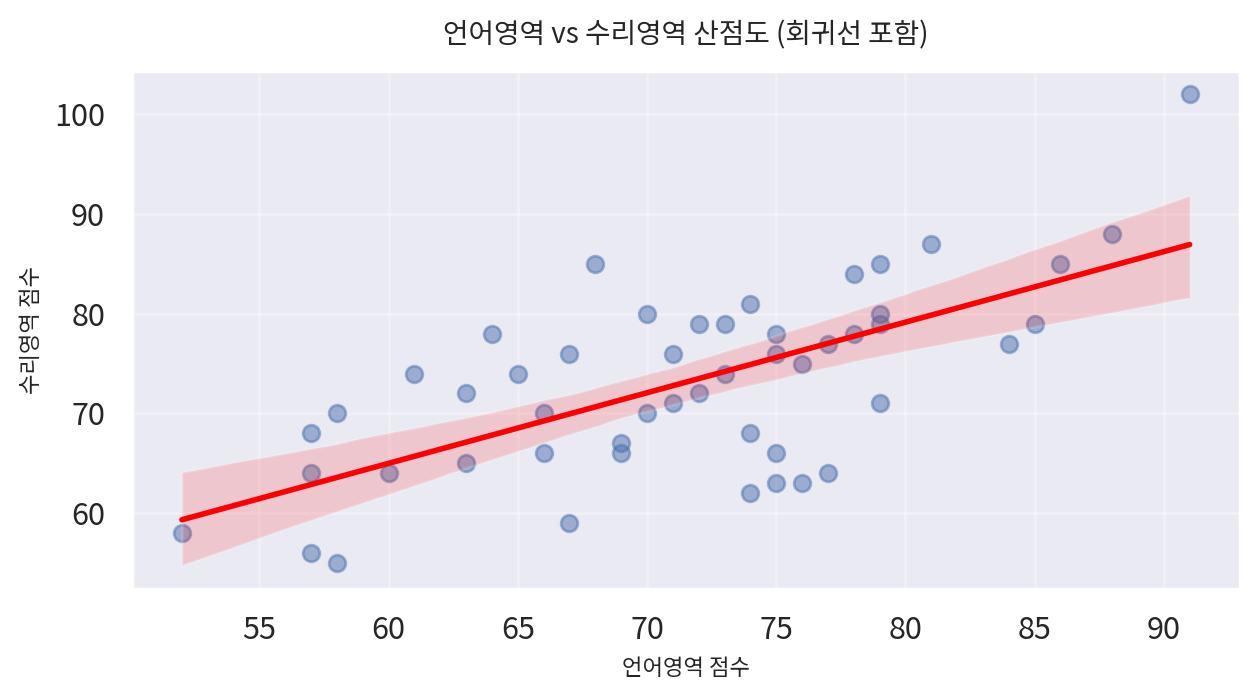

In [54]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='언어영역', y='수리영역',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
ax.set_title("언어영역 vs 수리영역 산점도 (회귀선 포함)", fontsize=10, pad=10)
ax.set_xlabel("언어영역 점수", fontsize=8 )
ax.set_ylabel("수리영역 점수", fontsize=8 )
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

선형성 통계적 검정(Ramsey RESET Test)
- 회귀 모델이 선형인지 검정하는 방법
- p>0.05 : 선형성 적합(피어슨 상관계수 사용 가능)
- p<=0.05 : 선형성 위반(스피어만 상관계수 사용 권장)

In [55]:
x = origin['언어영역']
y = origin['수리영역']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.1884)


분포 왜도를 통한 이상치 점검

In [56]:
data = origin[['언어영역','수리영역']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
        'log_recommend': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df['outliers(|z| > 3)'] >0)>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3),log_recommend
언어영역,-0.102559,-1.735952,0,False
수리영역,0.367414,-1.529107,1,False


이상치가 발견되어 스피어만 상관계수 사용


상관 분석
- 피어슨 상관계수

In [11]:
pearson_r, pearson_p = pearsonr(origin['언어영역'], origin['수리영역'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p, "대립" if pearson_p <= 0.05 else "귀무")

'staticstic: 0.671, p-value: 0.000, 대립가설 채택'

In [12]:
spearman_r, spearman_p = spearmanr(origin['언어영역'], origin['수리영역'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: 0.599, p-value: 0.000, 대립가설 채택'

가정에 따른 상관계수 선택
- 선형 + 왜도/이상치 영향 적음 -> 피어슨 우선
- 단조 비선형 또는 이상치 많음/왜도 큼 -> 스피어만 우선

In [14]:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('상관계수 요약')
print('=' * 50)
print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('최종 선택 결과')
print('=' * 50)
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('=' * 50)

상관계수 요약
Pearson r: 0.671, p-value: 0.0000
Spearman rho: 0.599, p-value: 0.0000

최종 선택 결과
선택된 방법: spearman
상관계수: 0.599
p-value: 0.0000
선택 근거: 비선형(또는 이상치 영향) 가능성 고려


상관 행렬
- 여러 변수들 간의 상관계수를 한 눈에 볼 수 있도록 정리한 표
- 행과 열에 같은 변수들이 배치
- 대각선 값은 항상 1 (자기 자신과의 상관계수)
- 대칭 행렬입니다(A와 B의 상관 계수 = B와 A의 상관계수)

**해석 방법**
- 1에 가까울수록: 강한 양의 상관관계(한 변수가 증가하면 다른 변수도 증가)
- -1에 가까울수록: 강한 음의 상관관계(한 변수가 증가하면 다른 변수는 감소)
- 0에 가까울수록: 상관관계가 없음(두 변수는 서로 독립적)

In [16]:
corr_matrix = origin[['언어영역','수리영역']].corr(method=chosen)
corr_matrix

,언어영역,수리영역
언어영역,1.000000,0.599095
수리영역,0.599095,1.000000


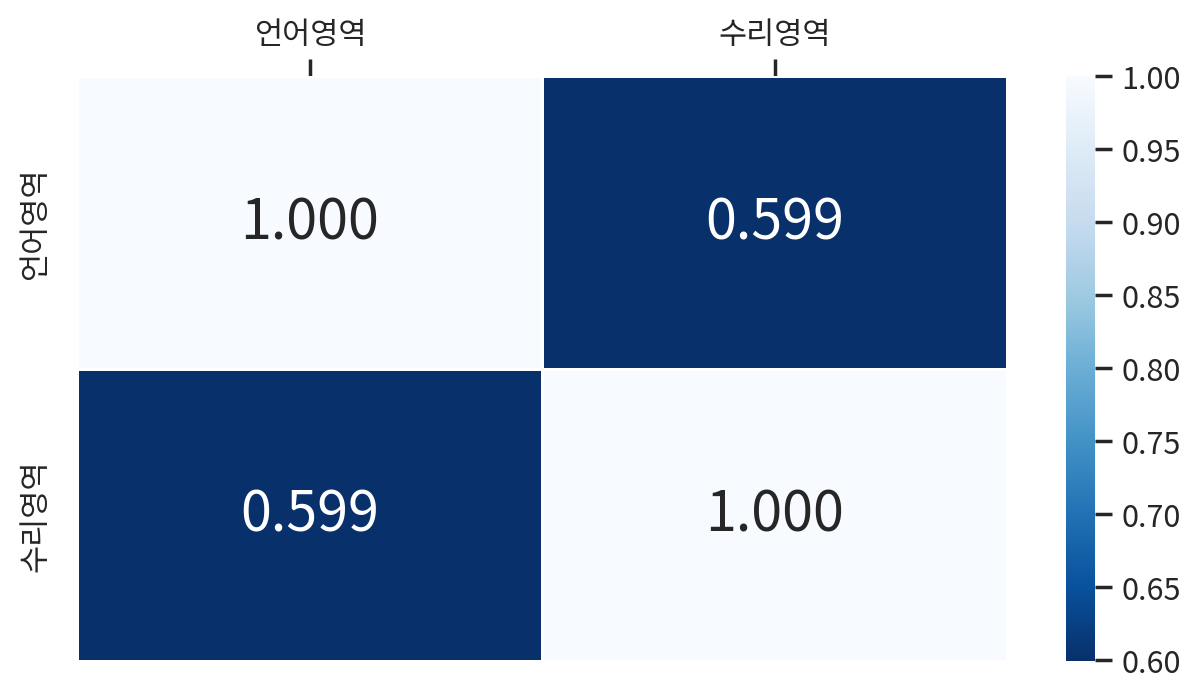

In [18]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

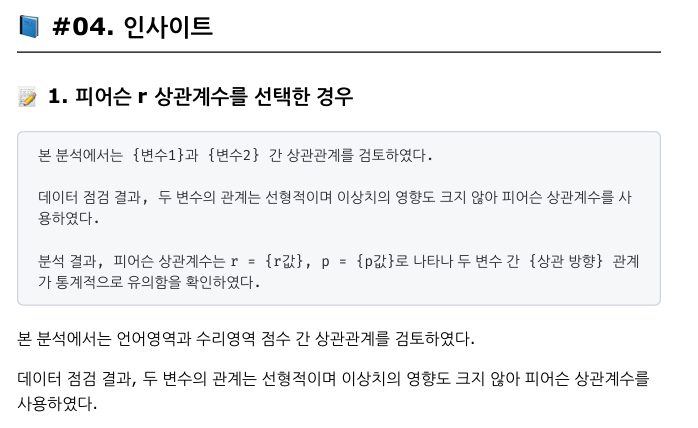
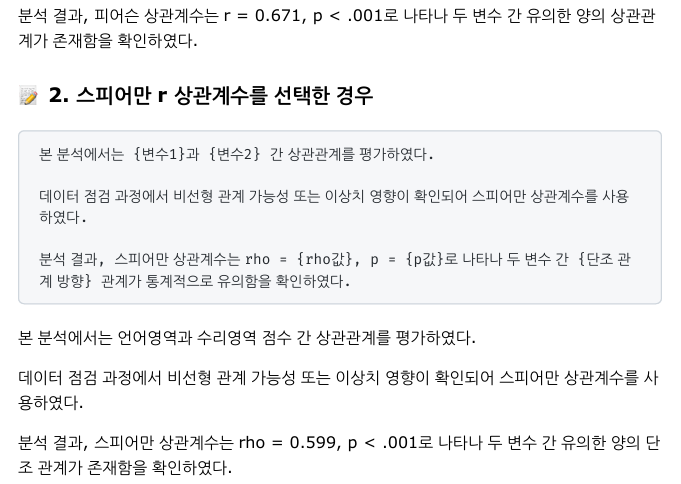

연습문제 1.
- baseball 데이터셋은 야구팀의 홈런수와 타율에 관한 자료이다. 홈런수와 평균타율이 상관관계가 있는지 그 관련성을 분석하라.

In [58]:
origin = load_data('baseball')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/baseball.xlsx
[desc] 야구팀의 홈런수와 타율에 관한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (14, 2)
열 개수: 2
행 개수: 14

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   홈런수     14 non-null     int64  
 1   평균타율    14 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 356.0 bytes
None


,홈런수,평균타율
0,174,0.277
1,163,0.276
2,161,0.272
3,230,0.272
4,214,0.269


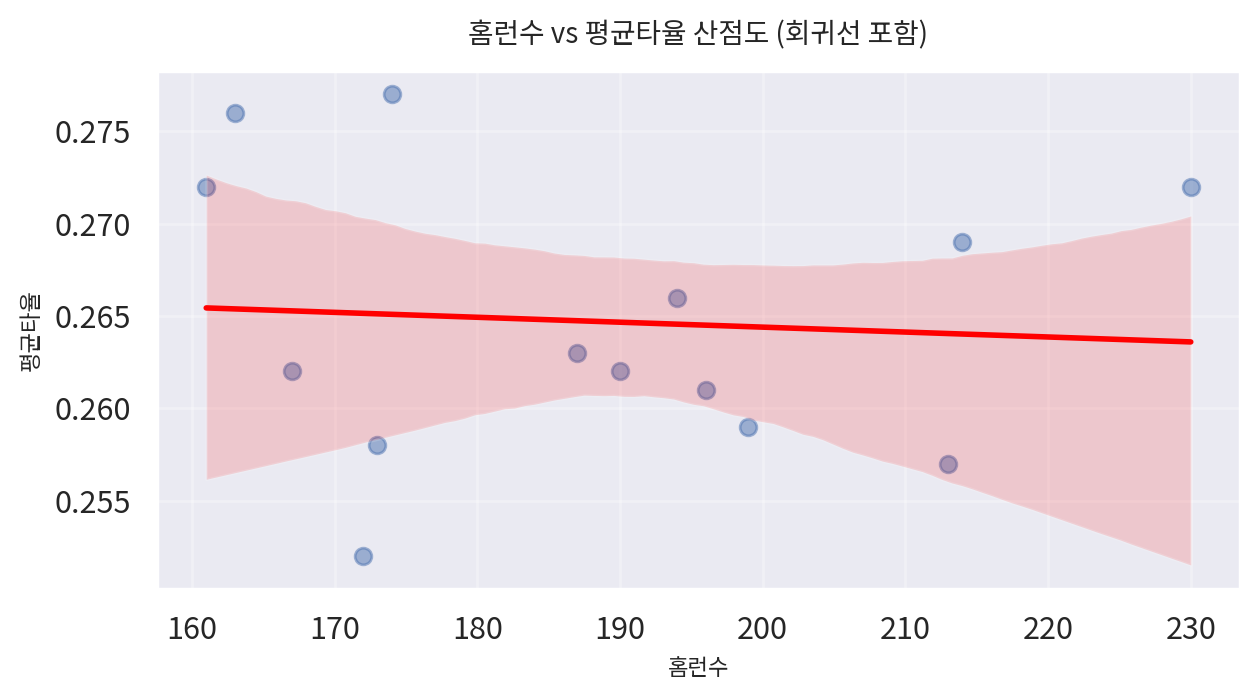

In [59]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='홈런수', y='평균타율',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
ax.set_title("홈런수 vs 평균타율 산점도 (회귀선 포함)", fontsize=10, pad=10)
ax.set_xlabel("홈런수", fontsize=8 )
ax.set_ylabel("평균타율", fontsize=8 )
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [60]:
x = origin['홈런수']
y = origin['평균타율']
xname = '홈런수'
yname = '평균타율'
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.0910)


In [65]:
data = origin[['홈런수','평균타율']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3)'] >0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3)
홈런수,0.512832,-0.974080,0.0
평균타율,0.220918,0.214929,0.0


이상치가 발견되지 않아 피어슨 상관계수 사용


In [66]:
pearson_r, pearson_p = pearsonr(origin['홈런수'], origin['평균타율'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p, "대립" if pearson_p <= 0.05 else "귀무")

'staticstic: -0.075, p-value: 0.800, 귀무가설 채택'

In [27]:
spearman_r, spearman_p = spearmanr(origin['홈런수'], origin['평균타율'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: -0.130, p-value: 0.658, 귀무가설 채택'

In [67]:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'

    report = f"본 분석에서는 {xname}과 {yname} 간 상관관계를 검토하였다.\n\n데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다. \n\n분석결과, 피어슨 상관계수는 r = {corr:0.3f}, p={pval:0.3f}(으)로 나타나 두 변수 간 {"양의 상관"if corr>0 else "음의 상관"} 관계가 통계적으로 유의함을 확인하였다."
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'
    report = f"본 분석에서는 {xname}과 {yname} 간 상관관계를 검토하였다.\n\n데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다. \n\n분석결과, 스피어만 상관계수는 r = {corr:0.3f}, p={pval:0.3f}(으)로 나타나 두 변수 간 {"양의 단조"if corr>0 else "음의 단조"} 관계가 존재함을 확인하였다."

print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('\n====== report ======\n')
print(report)

선택된 방법: pearson
상관계수: -0.075
p-value: 0.7997
선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단

====== report ======

본 분석에서는 홈런수과 평균타율 간 상관관계를 검토하였다.

데이터 점검 결과, 두 변수의 관계는 선형적이며 이상치의 영향도 크지 않아 피어슨 상관계수를 사용하였다. 

분석결과, 피어슨 상관계수는 r = -0.075, p=0.800(으)로 나타나 두 변수 간 음의 상관 관계가 통계적으로 유의함을 확인하였다.


In [68]:
corr_matrix = origin[['홈런수','평균타율']].corr(method=chosen)
corr_matrix

,홈런수,평균타율
홈런수,1.000000,-0.074695
평균타율,-0.074695,1.000000


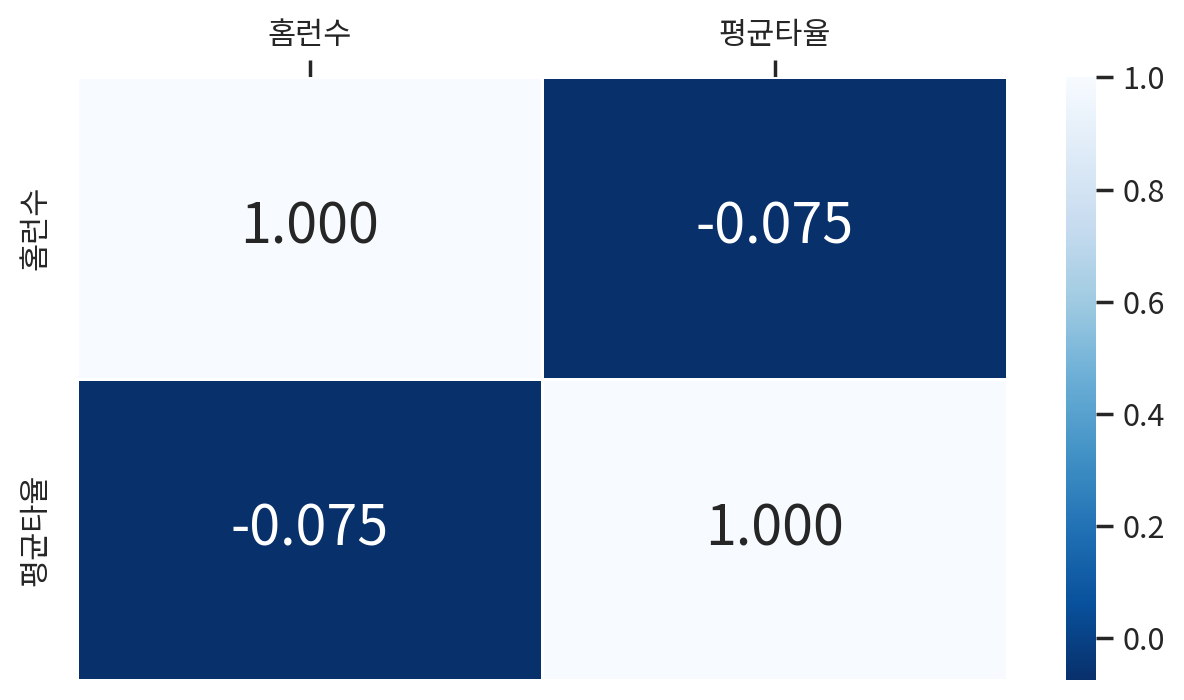

In [69]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

- 본 분석에서는 홈런수와 평균 타율 간 상관관계를 평가하였다.
- 데이터 점검 과정에서 비선형 관계 가능성 또는 이상치 영향이 확인되어 스피어만 상관계수를 사용하였다.
- 분석 결과 스피어만 상관계수는 rho = -0.130, p=0.6579로 나타나 두 변수 간 유의한 음의 단조 관계가 존재함을 확인하였다.


연습문제 2.

- product데이터 셋은 어떤 원료의 품질특성(x)과 이 원료를 사용하여 만든 제품의 특성(y)에 관한 조사를 한 결과이다.
- 이들 간 상관관계를 구하고 상관 유무 검정을 유의수준 5%에서 실시하라.

In [70]:
origin = load_data('product')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/product.xlsx
[desc] 어떤 원료의 품질특성(x)과 이 원료를 사용하여 만든 제품의 특성(y)에 관한 조사결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (10, 2)
열 개수: 2
행 개수: 10

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       10 non-null     int64
 1   y       10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes
None


,x,y
0,36,29
1,40,32
2,34,29
3,44,40
4,33,31


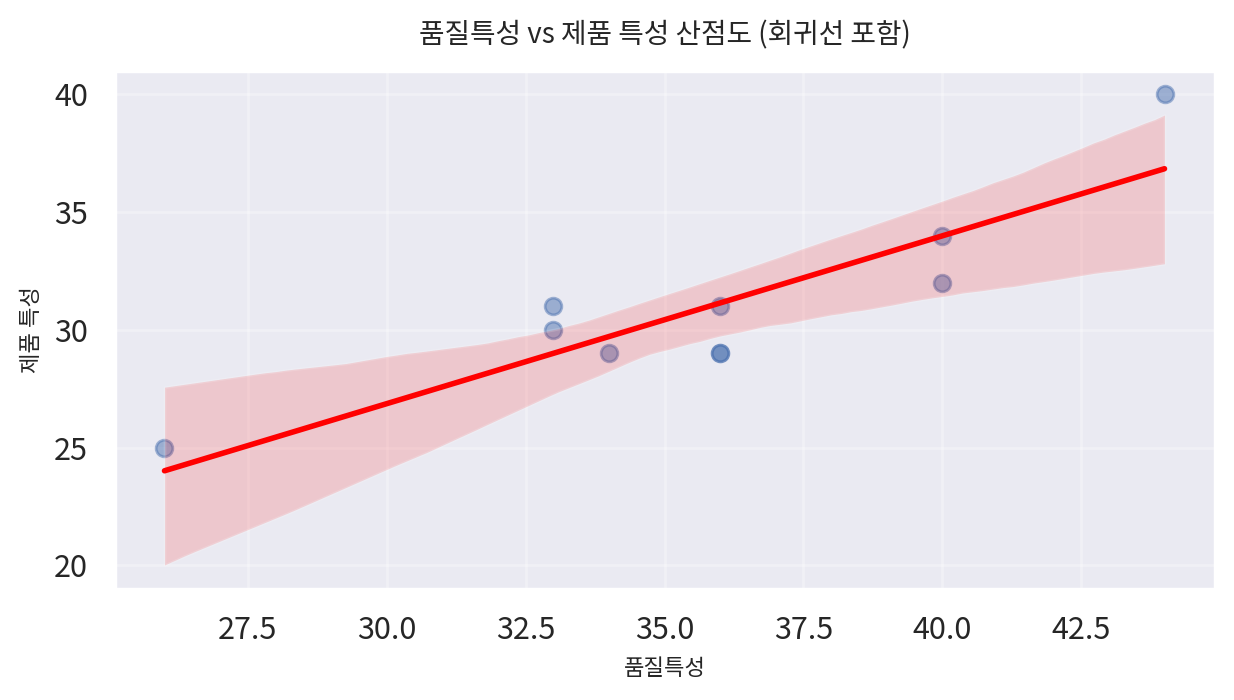

In [71]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='x', y='y',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
ax.set_title("품질특성 vs 제품 특성 산점도 (회귀선 포함)", fontsize=10, pad=10)
ax.set_xlabel("품질특성", fontsize=8 )
ax.set_ylabel("제품 특성", fontsize=8 )
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [72]:
x = origin['x']
y = origin['y']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.1206)


In [74]:
data = origin[['x','y']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
        'log_recommend': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3)'] >0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3),log_recommend
x,-0.340387,-2.178627,0,False
y,1.168124,-1.066498,0,True


이상치가 발견되지 않아 피어슨 상관계수 사용


In [76]:
pearson_r, pearson_p = pearsonr(origin['x'], origin['y'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p, "대립" if pearson_p <= 0.05 else "귀무")

'staticstic: 0.888, p-value: 0.001, 대립가설 채택'

In [75]:
spearman_r, spearman_p = spearmanr(origin['x'], origin['y'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: 0.737, p-value: 0.015, 대립가설 채택'

In [77]:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('상관계수 요약')
print('=' * 50)
print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('최종 선택 결과')
print('=' * 50)
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('=' * 50)

상관계수 요약
Pearson r: 0.888, p-value: 0.0006
Spearman rho: 0.737, p-value: 0.0151

최종 선택 결과
선택된 방법: pearson
상관계수: 0.888
p-value: 0.0006
선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단


In [78]:
corr_matrix = origin[['x','y']].corr(method=chosen)
corr_matrix

,x,y
x,1.000000,0.888052
y,0.888052,1.000000


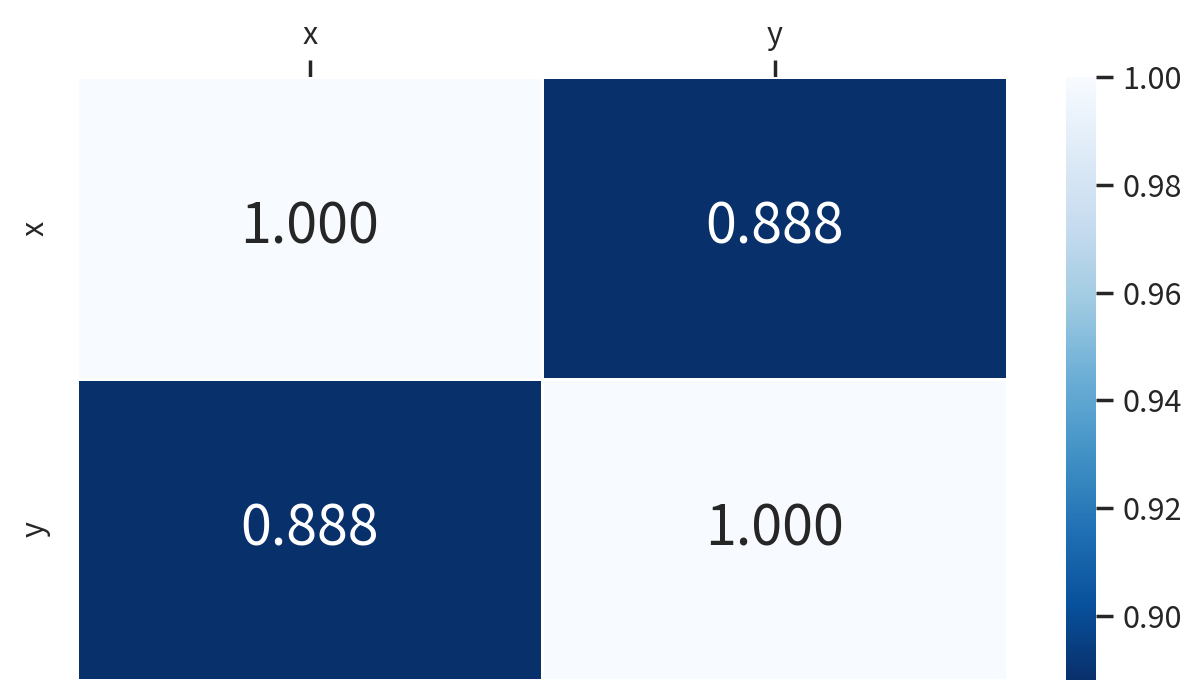

In [79]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

연습문제 3.

- study_time 은 학생들에 대한 공부 시간과 성적 데이터이다. 분석하라.

In [80]:
origin = load_data('study_time')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/study_time.xlsx
[desc] 학생들에 대한 공부 시간과 성적 데이터 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기 : (10, 2)
열 개수: 2
행 개수: 10

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   공부시간    10 non-null     int64
 1   성적      10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes
None


,공부시간,성적
0,2,65
1,4,85
2,3,75
3,5,90
4,6,95


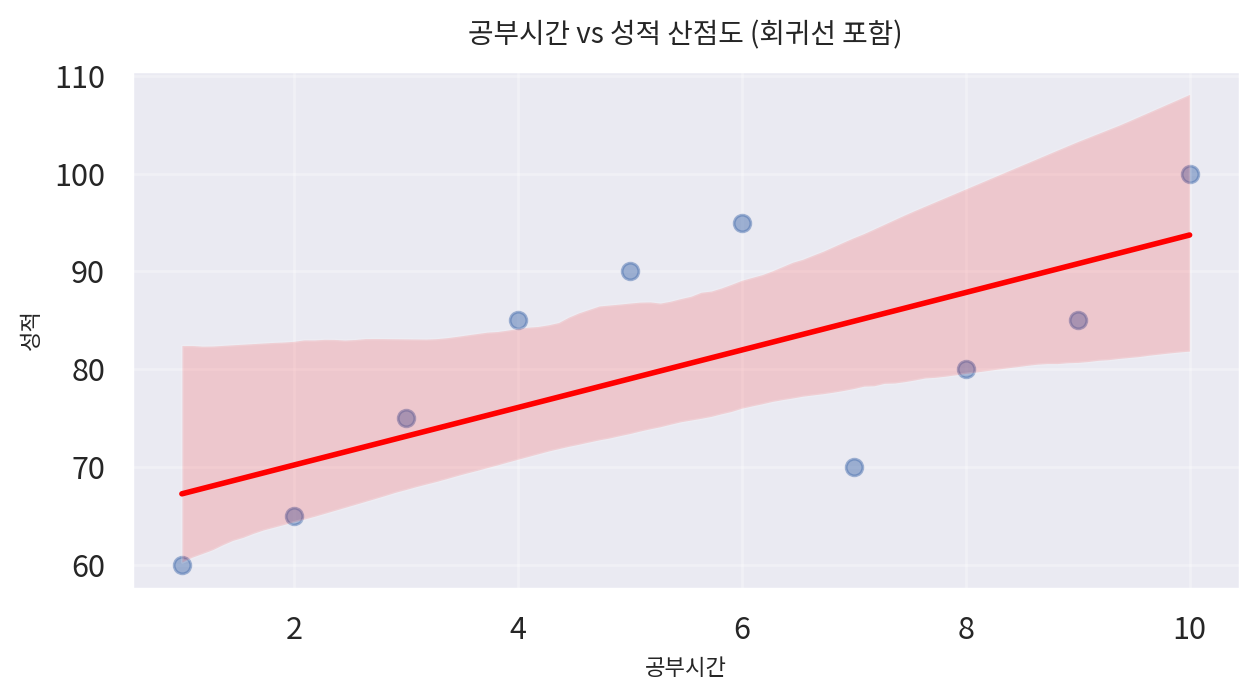

In [81]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=origin, x='공부시간', y='성적',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
ax.set_title("공부시간 vs 성적 산점도 (회귀선 포함)", fontsize=10, pad=10)
ax.set_xlabel("공부시간", fontsize=8 )
ax.set_ylabel("성적", fontsize=8 )
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

In [82]:
x = origin['공부시간']
y = origin['성적']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 적합 (p-value: 0.4234)


In [83]:
data = origin[['공부시간','성적']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
        'log_recommend': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3)'] >0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3),log_recommend
공부시간,0.0,-0.762678,0,False
성적,-0.136348,-1.573659,0,False


이상치가 발견되지 않아 피어슨 상관계수 사용


In [84]:
pearson_r, pearson_p = pearsonr(origin['공부시간'], origin['성적'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(pearson_r, pearson_p, "대립" if pearson_p <= 0.05 else "귀무")

'staticstic: 0.684, p-value: 0.029, 대립가설 채택'

In [44]:
spearman_r, spearman_p = spearmanr(origin['공부시간'], origin['성적'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: 0.657, p-value: 0.039, 대립가설 채택'

In [85]:
if linearity_ok and not outlier_flag:
    chosen = 'pearson'
    corr, pval = pearson_r, pearson_p
    rationale = '선형성 만족 + 왜도/이상치 영향 작음으로 판단'
else:
    chosen = 'spearman'
    corr, pval = spearman_r, spearman_p
    rationale = '비선형(또는 이상치 영향) 가능성 고려'

print('=' * 50)
print('상관계수 요약')
print('=' * 50)
print(f"Pearson r: {pearson_r:.3f}, p-value: {pearson_p:.4f}")
print(f"Spearman rho: {spearman_r:.3f}, p-value: {spearman_p:.4f}")

print('\n' + '=' * 50)
print('최종 선택 결과')
print('=' * 50)
print(f"선택된 방법: {chosen}")
print(f"상관계수: {corr:.3f}")
print(f"p-value: {pval:.4f}")
print(f"선택 근거: {rationale}")
print('=' * 50)

상관계수 요약
Pearson r: 0.684, p-value: 0.0291
Spearman rho: 0.737, p-value: 0.0151

최종 선택 결과
선택된 방법: pearson
상관계수: 0.684
p-value: 0.0291
선택 근거: 선형성 만족 + 왜도/이상치 영향 작음으로 판단


In [86]:
corr_matrix = origin[['공부시간','성적']].corr(method=chosen)
corr_matrix

,공부시간,성적
공부시간,1.000000,0.684236
성적,0.684236,1.000000


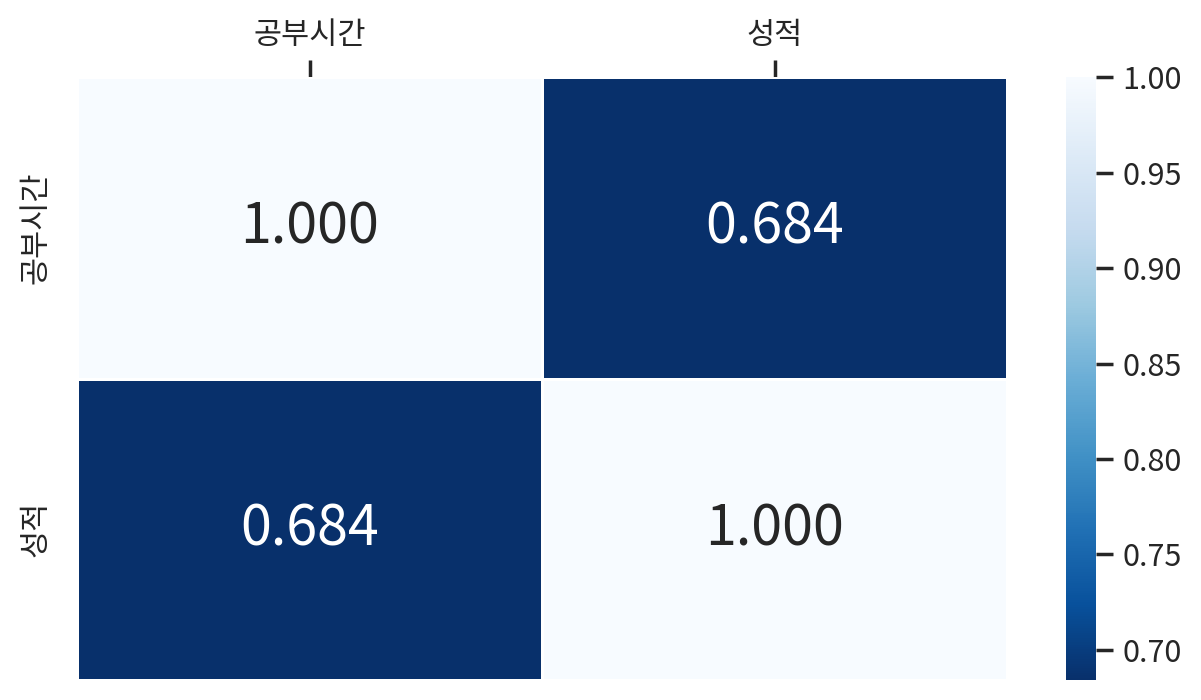

In [87]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.3f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':20})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()